# mSSA Running Example

In this notebook, we showcase the core  functionalities of the **mSSA** on both Synthetic and Real world dataset



### To run this test, you need:

**(1)** our mSSA package 

**(2)** numpy, pandas and matplotlib packages installed




In [1]:
# Import the packages
from mssa.mssa import mSSA
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np


## Synthetic Dataset

The dataset we will be using is synthetically generated from a time-varying mean that is a mixture of harmonics, trend, and a time-varying variance that is generated via a mixture of harmonics.

Two files are in the `test_data/tables` folder:

**(1)** `MixtureTS_var.csv`: which we will use as our *training* set, which has 100k rows

**(2)** `MixtureTS_var_test.csv`: which we will use as our *test* set for forecasts, which has 10k rows.

Let's inspect the data in the file `mixturets_var.csv` ..





In [6]:
data = pd.read_csv("testdata/tables/MixtureTS_var.csv", index_col = 'time')
data.head()

,ts,means,ts_9,ts_7,var
time,,,,,
0,-7.765942,-5.000000,-7.765942,-7.765942,4.986913
1,-8.130908,-4.058822,-8.130908,-8.130908,4.928091
2,-7.785026,-3.843015,-7.785026,NaN,4.869337
3,-5.195306,-3.707296,-5.195306,NaN,4.810716
4,0.657312,-3.610115,0.657312,0.657312,4.752293


Our time series data consist of 6 columns, namely:

**(1) time**: (int) this column represent the time index as integers

**(2) means:** (float) Where the underlying mean of the time series is stored. Note that since this data is synthetically generated, we know what is the underlying mean of the generation process

**(3) ts:** (float) Where the observation of the time series are stored

**(4) ts_7:** (float) Where 70% the observation of the time series are stored, and 30 % are artificially masked

**(5) ts_9:** (float) Where 90% the observation of the time series are stored, and 10 % are artificially masked

**(6) var:** (float) Where the underlying time-varying variance of our time series is stored




In this example, we will use the `ts_7` column, where 30% of the data are missing, and we will estimate the imputation and forecasting accuracy by comparing them with the real underlying mean. 


### Train mSSA model
Now, we will train the mSSA model, which allows for retreiving predicted values for entries that are: 

**(1)** At a future time step (i.e. forecasting), 

**(2)** Missing/corrupted by noise (i.e. imputation)

In addition to that, it will also estimate the underlying time-varying variance of the time series, which allow users to produce upper and lower bound for their prediction.  

Let's train the model on the column **ts_7**. Note that we set the `fill_in_missing` to True, this option interpolate some of the missing values by forward filling the missing observation, followed by a backward filling. Setting this option to True can help in some datasets.  

In [19]:
model = mSSA(fill_in_missing = True)
# model
model.update_model(data.loc[:,['ts_7']])

(100000, 1)


### Imputation predictions

#### Simple example

Before imputing the data, let's look at the value of `ts_7` at time 1000 in the dataframe. 

In [20]:
data.loc[1000,'ts_7']

nan

We can see that the value is missing at time 1000. Let's check what was the underlying mean of our data at the same time, which we can get from the dataframe.

In [21]:
data.loc[1000,'means']

9.081747534662645

Idealy, we would like mSSA to *predict* the value `9.081748` for `ts_7` at time = 1000. Let's see what mSSA produces using the function `predict()`

In [22]:
df = model.predict('ts_7',1000)
df

,Mean Predictions,Lower Bound,Upper Bound
1000,8.617548,3.279099,13.955998


The predicted value is `8` with an lower bound of `3` and upper bound of ~ `14`. The confidence interval is fairly big! which indicate that the index estimate a fairly high variance at this point. Let's check the underlying variance from our data table. 

In [23]:
data.loc[1000,'var']

7.8484756101635575

Which is indeed a big variance that justifies the big confidence interval.

Let's now use the `predict()` function again to plot the first 100 imputed points, along with the observations `ts_7` and the underlying latent mean.

<IPython.core.display.Javascript object>


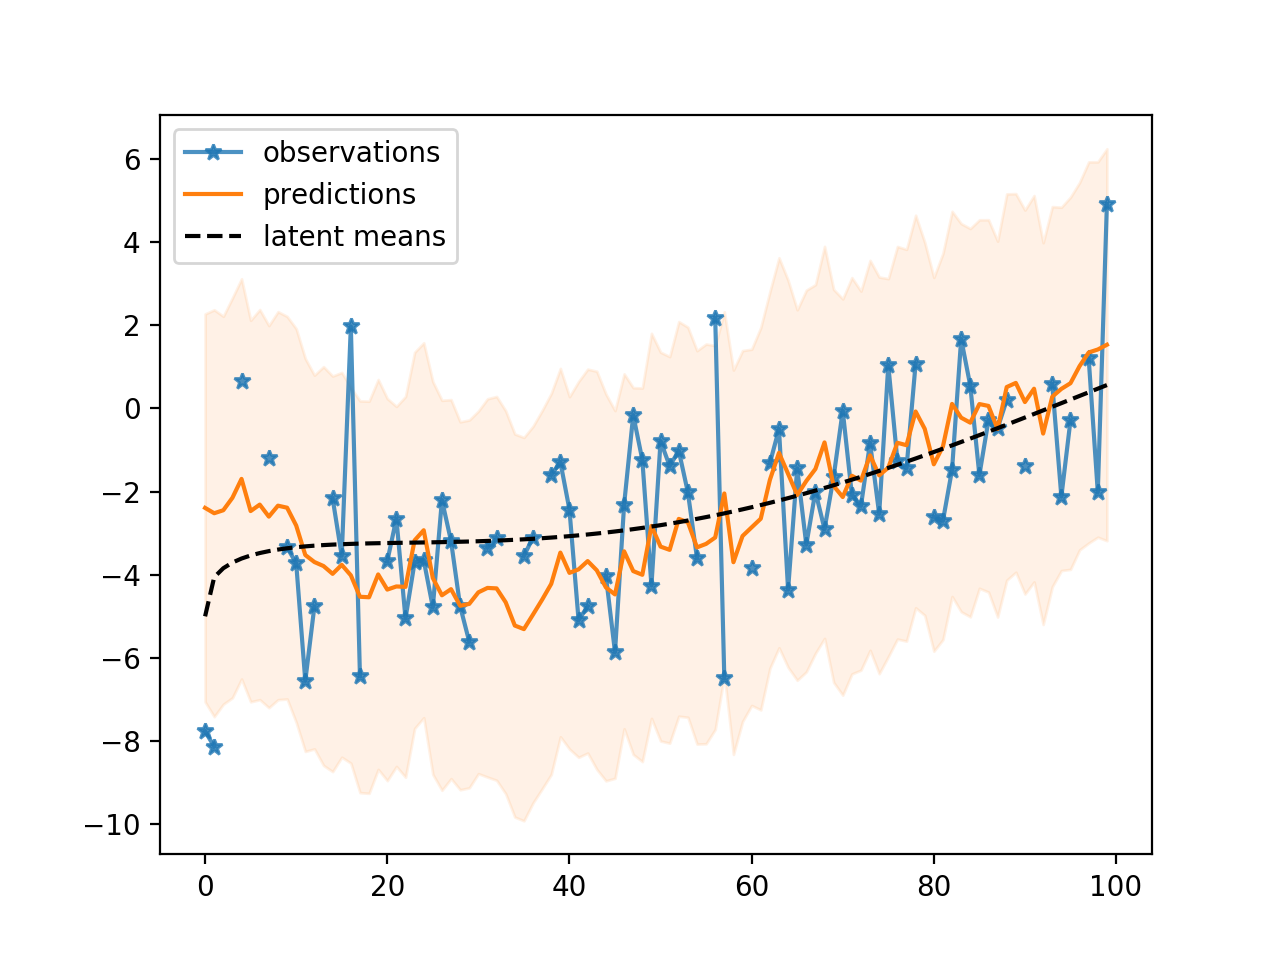

In [24]:
%matplotlib notebook
df = model.predict('ts_7',0,99)
df['time'] = np.arange(100)
plt.figure()
plt.plot(df['time'], data['ts_7'][:100],'-*', label = 'observations', alpha = 0.8)
plt.plot( df['Mean Predictions'], label = 'predictions')
plt.fill_between(df.index, df['Lower Bound'],df['Upper Bound'], color = 'tab:orange', alpha = 0.1)
plt.plot(df['time'], data['means'][:100],'--k', label = 'latent means', alpha = 1.0)
plt.legend()
plt.show()

Note that the predictions closely follow the underlying mean, even though 30% of the data is missing. Note also that the upper and lower bound estimates almost always envelop the observations. 

#### imputation Accuracy
To estimate the accuracy of our predictions, let's predict the first 1000 points and compare the predictions to the real underlying mean.  

<IPython.core.display.Javascript object>


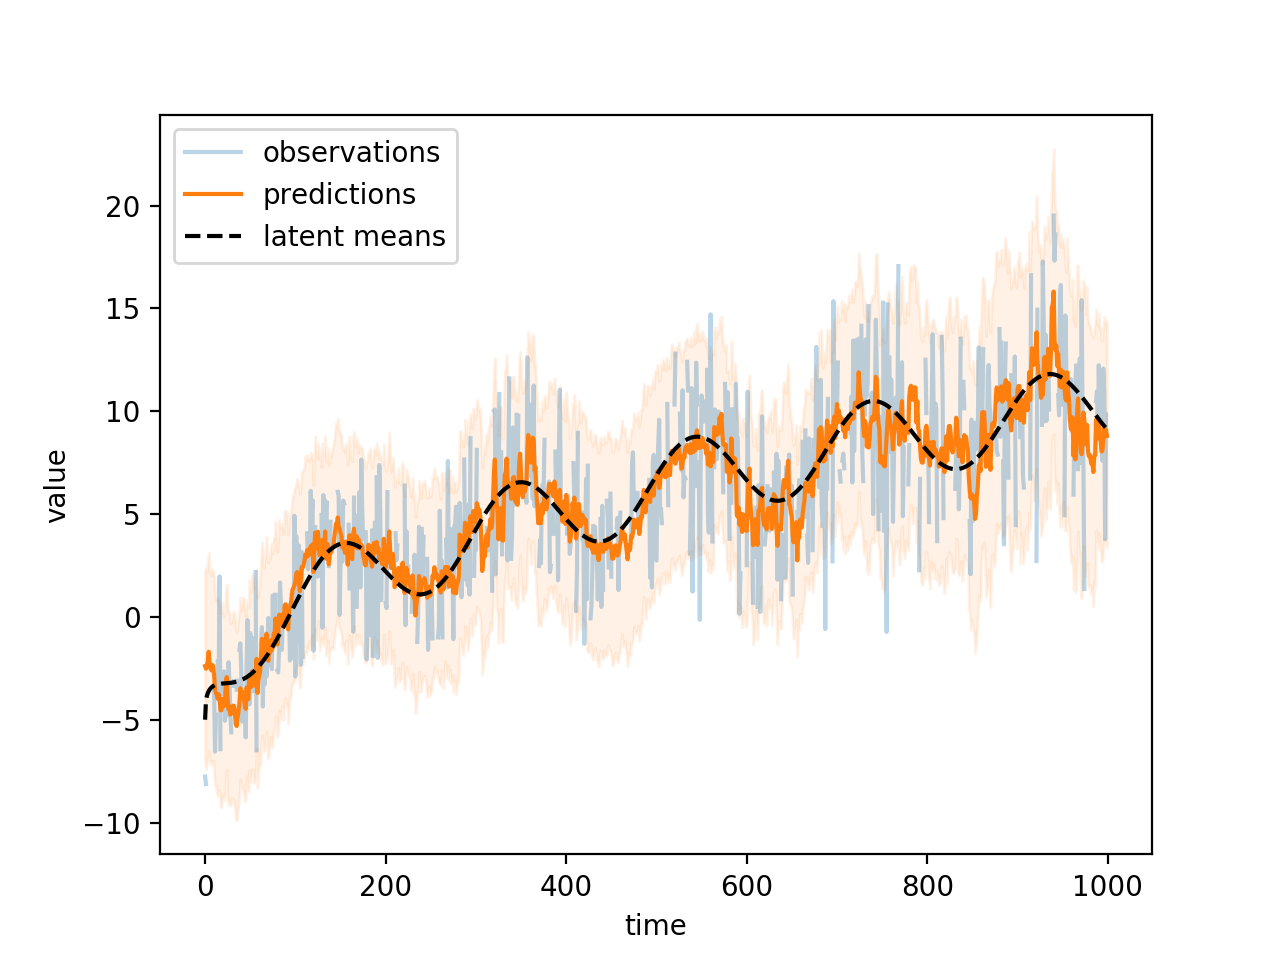

In [25]:

%matplotlib notebook
N = 1000
df = model.predict('ts_7',0,N-1)
df['time'] = np.arange(N)
plt.figure()
plt.plot(df['time'], data['ts_7'][:N], label = 'observations', alpha = 0.3)
plt.plot( df['Mean Predictions'], label = 'predictions')
plt.fill_between(df.index, df['Lower Bound'],df['Upper Bound'], alpha = 0.1, color = 'tab:orange', )
plt.plot(df['time'], data['means'][:N],'--k', label = 'latent means', alpha = 1.0)
plt.ylabel('value')
plt.xlabel('time')
plt.legend()

The mean Square Error (MSE) is:

In [26]:
print ('imputation accuracy (MSE):',np.mean(np.square(data['means'][:N]-df['Mean Predictions'])))

imputation accuracy (MSE): 1.1493149553463389


### Forecasting

In this example, we will forecast the next 100 points in our time series. That is, we will predict the value of `ts_7` from time = 100001 to time = 100100. We will then compare the result with the underlying mean.

First we will load the test dataset to compare our predictions with it

In [29]:
data_test = pd.read_csv('testdata/tables/MixtureTS_var_test.csv').iloc[:100]
means = data['means']

<IPython.core.display.Javascript object>


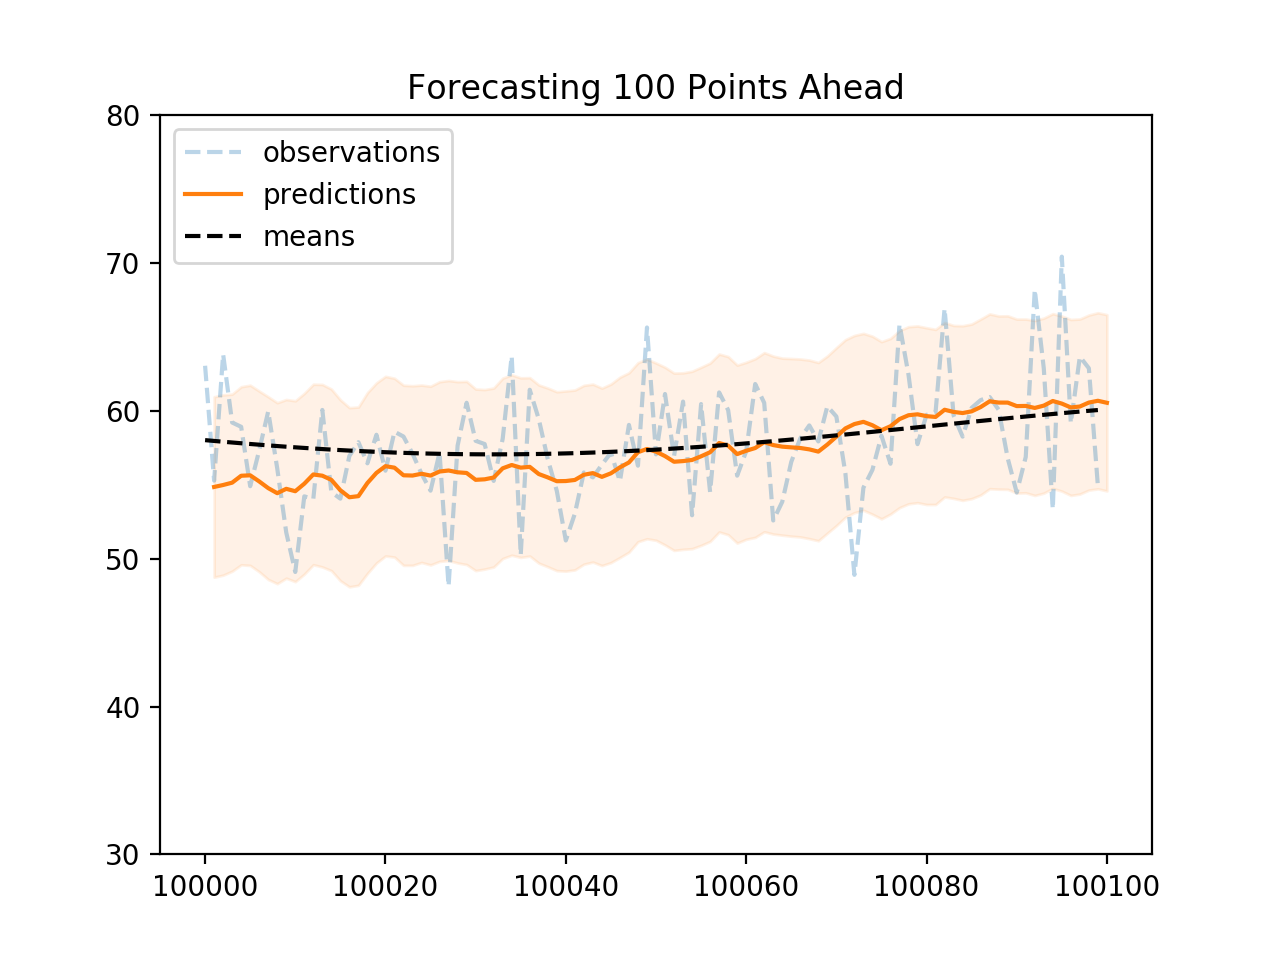

In [30]:
df = model.predict('ts_7', 100001,100100)
plt.figure()
plt.plot(data_test['time'], data_test['ts'],'--', label = 'observations', alpha = 0.3)
plt.plot( df['Mean Predictions'], label = 'predictions')
plt.fill_between(df.index, df['Lower Bound'],df['Upper Bound'], alpha = 0.1, color = 'tab:orange', )
plt.plot(data_test['time'], data_test['means'],'--k', label = 'means', alpha = 1.0)

plt.ylim([30,80])
plt.title('Forecasting 100 Points Ahead')
# plt.plot(df['time'], df['var'],'--', label = 'latent variance', alpha = 0.4)
plt.legend()

The MSE error is:

In [31]:
print ('Forecasting accuracy (MSE):',np.mean(np.square(data_test['means'][:100].values-df['Mean Predictions'].values)))


Forecasting accuracy (MSE): 2.0742969925391863


## Real World Dataset

- The dataset we will be using is a real world dataset available at the [UCI repository](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#). The dataset describes the 15-minutes load for 370 houses. 
- We will aggregate the data into horly data and split it into a training set with  25968 time-points, and a test set that has 168 datapoints.  The forecasting task here is to perform rolling window hourly forecasting for the next 7 days by forecasting one day at a time. First we will download the data from the UCI repository. 

**NOTE:** The dataset size is ~ 250 MB, so it might take a while depending on your connection.


In [32]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
!unzip LD2011_2014.txt.zip
# change commas to dots
!sed 's/,/./g' LD2011_2014.txt > LD2011_2014_clean.txt

--2020-09-11 11:33:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261335609 (249M) [application/x-httpd-php]
Saving to: ‘LD2011_2014.txt.zip’

LD2011_2014.txt.zip 100%[===================>] 249.23M  4.29MB/s    in 55s     

2020-09-11 11:34:38 (4.51 MB/s) - ‘LD2011_2014.txt.zip’ saved [261335609/261335609]

Archive:  LD2011_2014.txt.zip
  inflating: LD2011_2014.txt         
   creating: __MACOSX/
  inflating: __MACOSX/._LD2011_2014.txt  


Let's now load and preprocess the data. Specifically we will:

1- Pick the first 20 houses `MT-001`to `MT-020`


2- Remove the data before 2011, since most of its readings are zeros

3- Aggregate the data into hourly readings by avergaing the 15-minutes readings.



In [33]:
data = pd.read_csv('LD2011_2014_clean.txt', delimiter = ';')
#remove data before 2012
data = data.iloc[8760*4:]
print('data loaded..')
data_2 = data.copy()
#pick the first 20 houses
data_2 = data_2.iloc[:,:21]
# Aggregate
data_2['time'] =pd.to_datetime(data_2['Unnamed: 0']).dt.ceil('1h') 
data_2 = data_2.drop(['Unnamed: 0'], axis = 1)
agg_dict = {}
for col in data_2.columns[:-1]:
    agg_dict[col] ='mean'
data_3 = data_2.groupby(['time']).agg(agg_dict)
print('data aggregated..')
data_2.shape

data loaded..
data aggregated..


(105216, 21)

Now each column of the dataframe `data` contains hourly reading starting from `2012-01-01 01:00` until `2015-01-01 01:00`. In this experiment, as mentioned before, we will split the observations into a training and testing sets. Specifically, the training set will start at  `2012-01-01 01:00` until `2014-12-18 00:00`. and the test set will have the rest of the observations.




Splitting the data into training and testing sets:

In [34]:
data_train = data_3.iloc[:25968]
data_test = data_3.iloc[25968:]


### Inspect the data

Now that the data is loaded, let's check the first 10 entries of the dataframe

In [35]:
data_train.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
time,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,4.124365,22.759602,77.324066,138.211382,72.256098,348.214286,8.620690,279.461279,72.989510,87.903226,59.798808,0.0,47.678275,36.534780,0.0,55.096811,76.145553,328.274760,15.577889,55.066079
2012-01-01 02:00:00,4.758883,23.115220,77.324066,137.195122,70.121951,339.285714,6.924816,276.094276,67.307692,82.258065,55.886736,0.0,46.019900,34.141672,0.0,52.249431,73.225517,305.910543,15.452261,51.101322
2012-01-01 03:00:00,4.124365,22.937411,77.324066,136.686992,66.463415,286.458333,6.642171,239.898990,63.811189,72.043011,54.582712,0.0,43.532338,33.024888,0.0,43.422551,61.994609,276.357827,14.070352,48.458150
2012-01-01 04:00:00,4.758883,22.048364,77.324066,102.134146,50.304878,191.964286,4.804975,200.336700,41.520979,46.236559,38.189270,0.0,35.862355,26.005105,0.0,35.449886,46.495957,188.498403,7.663317,39.427313
2012-01-01 05:00:00,4.441624,21.870555,77.324066,81.808943,45.121951,155.505952,3.533070,180.134680,45.891608,42.473118,33.904620,0.0,42.288557,24.409700,0.0,33.599089,35.265049,160.543131,6.155779,34.361233



## Fit mSSA

Now, using **mSSA**, we will be able to forecast and impute the data at past and future timesamps! To do that, we must first fit the model.



In [56]:
model = mSSA(rank = 20)
# model
model.update_model(data_train)

(25968, 20)


Note that the mSSA class can take several parameters that might affect its performance. Specifically, the parameter **rank** (int),  which determines the number of singular values to retain in the means prediction model. The default value is None, where the model will choose an appropriate rank using the method in the paper: (Gavish, Matan, and David L. Donoho. "The optimal hard threshold for singular values is $4/\sqrt {3} $")


## Prediction 

### Foracsting One hour ahead for the next  day

Let's  start by forecasting the first day for user `MT_020` and compare it visually with the test data.  Now we will produce the forecast for the next day using `predict` for the range `2014-12-18 01:00:00` to `2014-12-19  00:00:00` along with the 95% confidence interval.



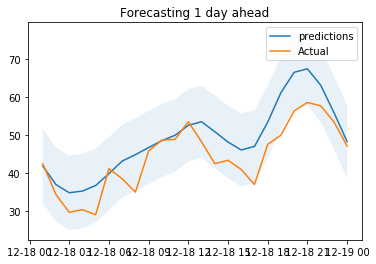

In [58]:
%matplotlib inline
df = model.predict('MT_020','2014-12-18 01:00:00','2014-12-19  00:00:00')


plt.figure()
plt.plot( df['Mean Predictions'], label = 'predictions')
plt.fill_between(df.index, df['Lower Bound'],df['Upper Bound'], alpha = 0.1)
plt.plot(data_test['MT_020'].iloc[:len(df['Mean Predictions'])], label = 'Actual', alpha = 1.0)
plt.title('Forecasting 1 day ahead')
plt.legend()
plt.show()


Note that the confidence used to produce the prediction interval can be changed by the user. For example, we can produce the predictions with a 99.9% confidence using the `confidence` parameter of the `predict` function.

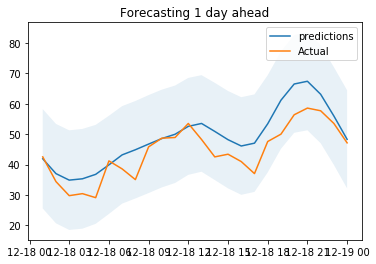

In [59]:
%matplotlib inline
df = model.predict('MT_020','2014-12-18 01:00:00','2014-12-19  00:00:00', confidence = 99.9)


plt.figure()
plt.plot( df['Mean Predictions'], label = 'predictions')
plt.fill_between(df.index, df['Lower Bound'],df['Upper Bound'], alpha = 0.1)
plt.plot(data_test['MT_020'].iloc[:len(df['Mean Predictions'])], label = 'Actual', alpha = 1.0)
plt.title('Forecasting 1 day ahead')
plt.legend()
plt.show()



### Forecast hourly data for all houses for the next seven days

Now, we will do a more quanitative test by forecasting the next seven days using a rolling window approach. Specifically, we will forecast the next seven days one day at a time for all 20 houses. **Note that between forecasts, we will incrementally train the on the already predicted timeframe.** 


In [60]:
#initialise prediction array
predictions = np.zeros((len(data_test.columns),24*7))
ub = np.zeros((len(data_test.columns),24*7))
lb = np.zeros((len(data_test.columns),24*7))
actual = data_test.values[:24*7,:]

# specify start time
start_time = pd.Timestamp('2014-12-18 01:00:00')

# predict for seven days
days = 7

for day in range(days):
    # get the final time stamp in the day
    end_time = start_time + pd.Timedelta(hours=23)
    # convert timestamps to string
    start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
    # predict for each house
    for i, column in enumerate(data_test.columns):
        # Forecast
        df_30 = model.predict(column,start_str,end_str)
        predictions[i,day*24:(day+1)*24] = df_30['Mean Predictions']
        ub[i,day*24:(day+1)*24] = df_30['Upper Bound']
        lb[i,day*24:(day+1)*24] = df_30['Lower Bound']
    
    # fit the model with the already predicted values 
    df_insert = data_test.iloc[day*24:24*(day+1),:]
    model.update_model(df_insert)
    
    # update start_time
    start_time = start_time + pd.Timedelta(hours=24)


(24, 20)
(24, 20)
(24, 20)
(24, 20)
(24, 20)
(6440,)
(6400,)
(24, 20)
(24, 20)


Let's calculate the error using the Root Mean Squared Error 


In [61]:
Y = actual[:,:]
Y_h = predictions.T[:,:]
mse = np.sqrt(np.mean(np.square(Y-Y_h)))
print ('Forecasting accuracy (RMSE):',mse)



Forecasting accuracy (RMSE): 20.014490274469672


Now, let's inspect our forecasts visually for all the 20 time series

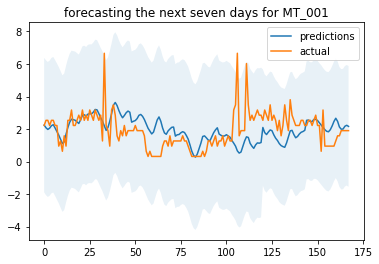

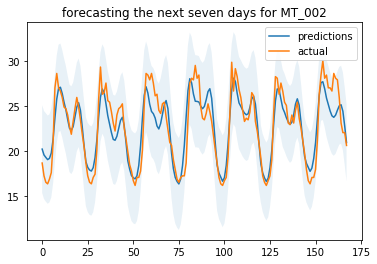

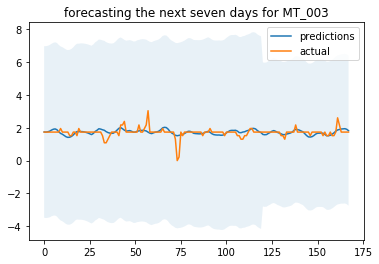

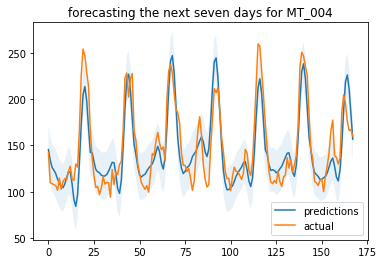

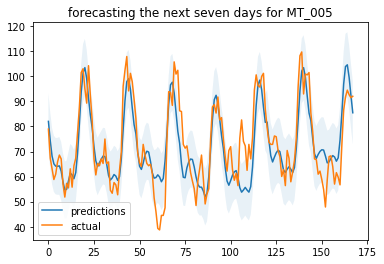

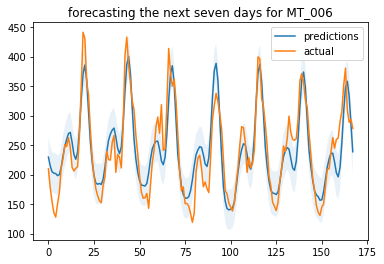

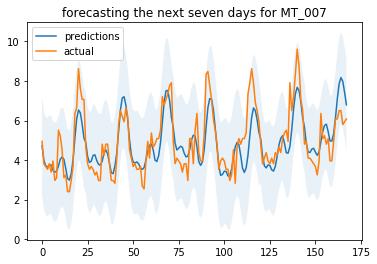

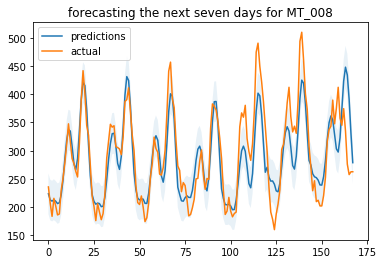

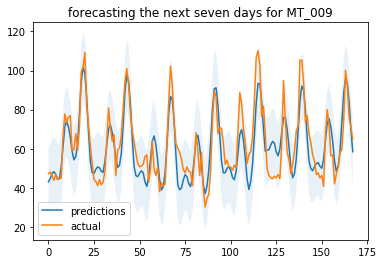

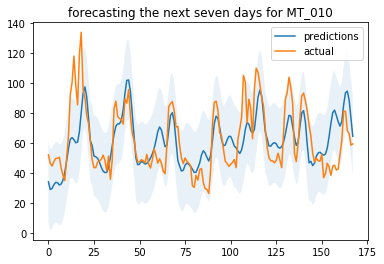

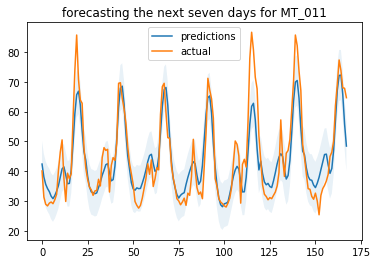

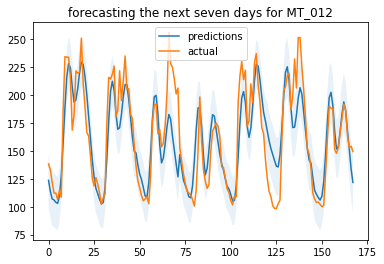

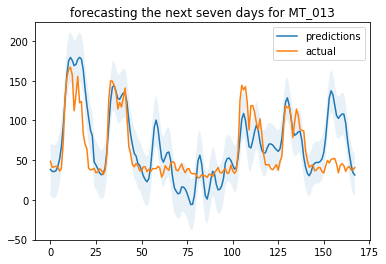

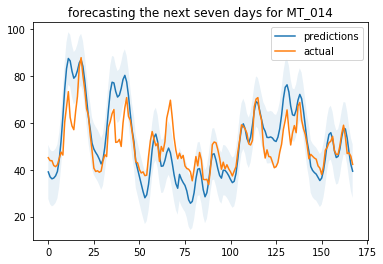

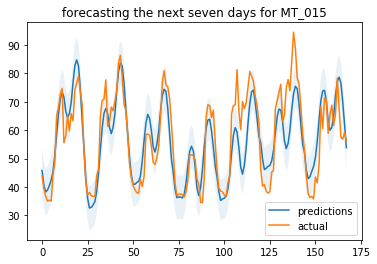

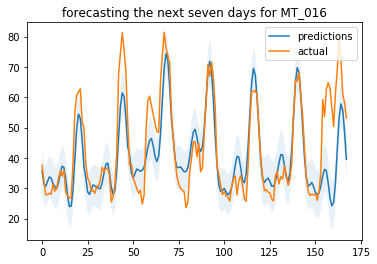

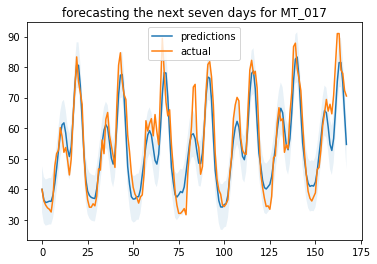

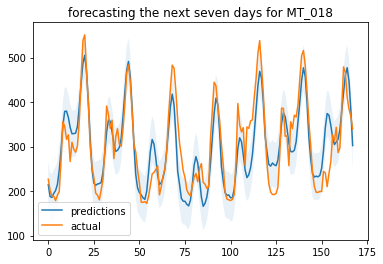

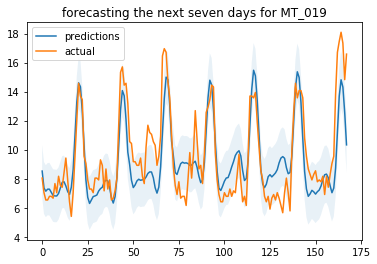

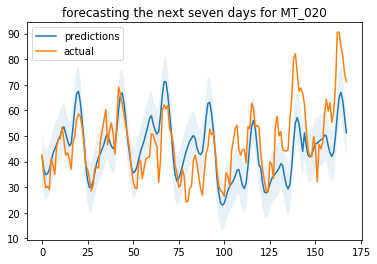

In [62]:
%matplotlib inline
for i in range(20):
    plt.figure()
    plt.title('forecasting the next seven days for %s'%data_test.columns[i])
    plt.plot(predictions[i,:24*7],label= 'predictions')
    plt.fill_between(np.arange(24*7), lb[i,:24*7], ub[i,:24*7], alpha = 0.1)
    plt.plot(actual[:24*7,i],label = 'actual')
    plt.legend()
plt.show()

### Aggregating with mSSA

This implementation allows you to pick an aggregating period (e.g. 1 hour, 2 hours, or 1 Day) and an aggregating function (from `average`, `min`,`max`) to preprocess your time series before fitting the model. 

For example, assume that instead of forecasting/imputing the hourly demand, we want to do it on a 2-hours interval. the `agg_period` and the `agg_method` option allow you to do that. 

In [11]:
# Specify the aggregation interval as two hours in seconds
model = mSSA(rank =20, agg_interval = 60*60*2 , agg_method = 'average')
# model
model.update_model(data_train)

In [12]:
# The predict function will now give a (2-hour)ly predictions
%matplotlib inline
df = model.predict('MT_020','2014-12-17 01:00:00','2014-12-19  00:00:00')


df


,Mean Predictions,Lower Bound,Upper Bound
2014-12-17 02:00:00,43.327925,34.236480,52.419370
2014-12-17 04:00:00,37.317044,28.396887,46.237200
2014-12-17 06:00:00,38.510394,29.492749,47.528040
2014-12-17 08:00:00,41.123833,31.792771,50.454896
2014-12-17 10:00:00,41.960999,32.437335,51.484662
2014-12-17 12:00:00,41.263625,31.955975,50.571275
2014-12-17 14:00:00,42.369707,33.166444,51.572970
2014-12-17 16:00:00,47.762772,38.839476,56.686068
2014-12-17 18:00:00,55.872018,47.225033,64.519003
2014-12-17 20:00:00,63.889814,55.351305,72.428323
